In [1]:
from collections import *
from numpy import *
import numpy as np
import csv
import sys
import json
import re
import nltk.data
import string
import sklearn.cluster
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xml.etree.ElementTree as ET
import sklearn.decomposition
import song_parsing
import collections
import sklearn.feature_extraction.text
from sklearn.decomposition import PCA
csv.field_size_limit(sys.maxsize);

In [17]:
N_CLUSTERS = 3

def get_all_words_and_word_counts(songs):
    all_words = set([])
    song_counters = {}
    for song in songs:
        words = []
        for line in songs[song].split('\n'):
            line = line.translate(None, string.punctuation)
            words.extend(line.replace('"', '').split(' '))

        counter = collections.Counter(words)
        song_counters[song] = counter
        all_words = all_words.union( counter.iterkeys() )

    length = len(all_words)
    all_words = sorted(all_words)
    return all_words, song_counters
    
def get_all_representations_as_matrix(songs, song_counters, all_words):
    all_song_representations = [[] for i in range(len(songs))]
    for word in all_words:
        for song_index, song in enumerate(songs):
            all_song_representations[song_index].append(song_counters[song[0]][word] * 1.0) 
    return all_song_representations
    
def get_clusters(songs):
    all_words, song_counters = get_all_words_and_word_counts(songs)
    songs = list(songs.iteritems())

    clusterer = sklearn.cluster.KMeans(n_clusters=N_CLUSTERS, max_iter=500) #make max_iter higher later

    all_song_representations = get_all_representations_as_matrix(songs, song_counters, all_words)
    
    #TF-IDF
    tfidf = sklearn.feature_extraction.text.TfidfTransformer(norm='l2',smooth_idf=True)
    communities = tfidf.fit_transform(all_song_representations).toarray()

    # #SVD
    svd = sklearn.decomposition.TruncatedSVD(n_components=len(all_song_representations[0])/2)
    all_song_representations = svd.fit_transform(all_song_representations)

    all_song_representations = np.array(all_song_representations) # as NP array
    cluster_labels = clusterer.fit_predict(all_song_representations)
    
    clusters = {}
    for song_index, cluster in enumerate(cluster_labels):
        if cluster not in clusters:
            clusters[cluster] = [songs[song_index][0]]
        else:
            clusters[cluster].append(songs[song_index][0])
    return all_song_representations, clusters, cluster_labels

In [18]:
songs = song_parsing.get_all_song_lyrics("Taylor Swift")
all_song_representations, clusters, cluster_labels = get_clusters(songs)

In [19]:
svd = sklearn.decomposition.TruncatedSVD(n_components=2)
t = svd.fit_transform(all_song_representations)

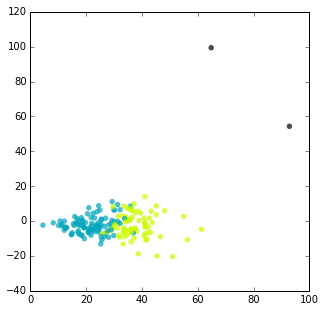

In [20]:
%matplotlib inline
plt.figure(figsize=(5,5))
colors = cm.spectral(cluster_labels.astype(float) / N_CLUSTERS)
plt.scatter(t[:, 0], t[:, 1], marker='.', s=120, lw=0, alpha=0.7, c=colors)
plt.show()

In [21]:
print collections.Counter(cluster_labels)
for cluster in clusters:
    print clusters[cluster]

Counter({1: 96, 2: 75, 0: 2})
['Shake It Off', 'I Wish You Would']
['A Place In This World', 'Long Time Coming', 'Silent Night', 'By The Way', 'One Way Ticket', 'Me And Britney', 'Angelina', 'This Is Really Happening', 'Made Up You', 'Change', "I'd Lie", 'Dark Blue Tennessee', 'Welcome To New York', 'Monologue Song (La La La)', 'Can I Go With You', 'New Romantics', 'Stay Beautiful', "I'm Only Me When I'm With You", 'Am I Ready For Love', 'I Heart ?', 'Lucky You', 'Long Live', 'Santa Baby', 'The Moment I Knew', 'Better Off', 'Christmas Must Be Something More', 'Riptide', 'Teardrops On My Guitar', 'Smokey Black Nights', 'Picture To Burn', 'Holy Ground', 'You Are In Love', 'Ours', 'Red', 'American Girl', 'Safe & Sound', 'Crazier', 'Girl At Home', 'Eyes Open', 'Superstar', 'I Know Places', 'We Were Happy', 'Come In With The Rain', 'A Perfectly Good Heart', 'Never Fade', 'Viva La Vida', 'This Love', 'Brought Up That Way', 'Just South Of Knowing Why', 'Your Face', 'Wonderland', 'Bette Davis 